In [156]:
# STEP 1 -  의존성 로드 ############################################################
import numpy as np
import pandas as pd
import os
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import seaborn as sns # seaborn ref : https://greeksharifa.github.io/machine_learning/2019/12/05/Seaborn-Module/
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import statsmodels.api as sm;
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process.kernels import RBF
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt # plotting
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
## 정확도 지표 정의
def metrics(y_test,pred):
    print("ACC : ",accuracy_score(y_test,pred))
    print("Precision : ", precision_score(y_test,pred))
    print("recall(TP rate) : ", recall_score(y_test,pred))
    print("F1 : " , f1_score(y_test,pred))
    print("ROC SCORE : ", roc_auc_score(y_test,pred,average="macro"))


%matplotlib inline
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

In [157]:
## DATA LOAD
df = pd.read_csv('2016_17_18_OUTCOME.csv')
df.head()
df.isnull()

,Unnamed: 0,age,wt_itvex,ainc,DI1_pr,DI2_pr,HE_DMfh3,HE_ht,HE_wc,HE_BMI,HE_DM,HE_chol,HE_HDL_st2,HE_TG,HE_hcv,HE_HCT,HE_Uro,HE_NNAL,HE_UCREA,BM7,GS_mea_r_1,N_WAT_C,N_INTK,N_PROT,N_SFA,N_N3,N_CHOL,N_CHO,N_TDF,N_SUGAR,N_FE,N_B1,intercept
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5489,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
5490,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
5491,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
5492,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [158]:
df=df.drop(columns=['intercept','Unnamed: 0'])
df.head()
#print('DATA IS : \n', pd.Series(df.HE_DM).value_counts())

,age,wt_itvex,ainc,DI1_pr,DI2_pr,HE_DMfh3,HE_ht,HE_wc,HE_BMI,HE_DM,HE_chol,HE_HDL_st2,HE_TG,HE_hcv,HE_HCT,HE_Uro,HE_NNAL,HE_UCREA,BM7,GS_mea_r_1,N_WAT_C,N_INTK,N_PROT,N_SFA,N_N3,N_CHOL,N_CHO,N_TDF,N_SUGAR,N_FE,N_B1
0,80,11065.346820,80.000000,1,1,0,162.4,82.2,21.233226,0,111,43.0,83,0.08,38.7,0,1.4,68.9,5,19.2,5.0,584.617278,36.421414,6.574070,0.573964,104.511252,97.066580,8.024705,14.110607,4.771832,0.664332
1,78,3688.448941,1500.000000,0,0,0,167.7,98.3,27.166096,1,224,36.0,157,0.10,42.6,0,1.4,100.1,5,40.5,5.0,1573.428467,93.260455,7.572577,0.333173,206.181421,298.257700,39.887760,93.915511,11.041512,1.175553
2,75,5244.077972,1500.000000,1,0,1,157.7,80.7,21.391845,1,165,44.0,101,12.06,42.3,0,1.4,105.1,5,15.3,5.0,1194.733365,42.516444,23.130683,2.193219,495.097017,320.072436,44.459450,120.949600,7.348493,0.638100
3,80,5244.077972,75.666667,0,0,0,146.1,93.0,26.984977,1,160,32.0,229,0.06,30.2,0,1.4,67.3,2,8.6,2.5,526.064249,24.806971,2.329953,0.356655,3.729000,211.241049,16.174439,22.942586,5.071129,0.877007
4,71,3315.581424,75.666667,1,0,1,157.2,78.4,21.528142,1,167,62.0,54,0.04,37.5,0,1.4,62.7,2,15.3,10.0,1271.085794,35.319840,16.748430,0.312280,65.398719,221.474668,20.316407,78.265128,4.773000,0.646209


In [159]:
df.isnull().sum()
df=df.fillna(0)

In [137]:
## SETTING DEPENDENT VAR, INDEPENDENT VARS 

Y = df.HE_DM # y축 설정
X = df.drop(columns=["HE_DM"]) #결과축 삭제 for predictions


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42) ## test.size 0.2~0.25 설정할거임

Learning rate set to 0.01831
0:	learn: 0.6795364	total: 16.5ms	remaining: 16.5s
1:	learn: 0.6654847	total: 22.8ms	remaining: 11.4s
2:	learn: 0.6527862	total: 29.8ms	remaining: 9.9s
3:	learn: 0.6400411	total: 38.1ms	remaining: 9.49s
4:	learn: 0.6259568	total: 47ms	remaining: 9.35s
5:	learn: 0.6137606	total: 56.3ms	remaining: 9.33s
6:	learn: 0.6026144	total: 65.4ms	remaining: 9.28s
7:	learn: 0.5918844	total: 74.8ms	remaining: 9.28s
8:	learn: 0.5815666	total: 81.8ms	remaining: 9.01s
9:	learn: 0.5708045	total: 93.7ms	remaining: 9.27s
10:	learn: 0.5609847	total: 101ms	remaining: 9.11s
11:	learn: 0.5521783	total: 114ms	remaining: 9.35s
12:	learn: 0.5430126	total: 123ms	remaining: 9.32s
13:	learn: 0.5343676	total: 131ms	remaining: 9.21s
14:	learn: 0.5263656	total: 137ms	remaining: 9.02s
15:	learn: 0.5188904	total: 142ms	remaining: 8.74s
16:	learn: 0.5117888	total: 148ms	remaining: 8.54s
17:	learn: 0.5045826	total: 152ms	remaining: 8.31s
18:	learn: 0.4975271	total: 157ms	remaining: 8.11s
19:	l

186:	learn: 0.2881788	total: 2.21s	remaining: 9.62s
187:	learn: 0.2878149	total: 2.22s	remaining: 9.6s
188:	learn: 0.2874754	total: 2.23s	remaining: 9.59s
189:	learn: 0.2872471	total: 2.24s	remaining: 9.57s
190:	learn: 0.2869050	total: 2.26s	remaining: 9.56s
191:	learn: 0.2866781	total: 2.27s	remaining: 9.54s
192:	learn: 0.2863609	total: 2.27s	remaining: 9.51s
193:	learn: 0.2860159	total: 2.28s	remaining: 9.47s
194:	learn: 0.2857505	total: 2.28s	remaining: 9.43s
195:	learn: 0.2854221	total: 2.29s	remaining: 9.39s
196:	learn: 0.2850785	total: 2.29s	remaining: 9.36s
197:	learn: 0.2847553	total: 2.3s	remaining: 9.32s
198:	learn: 0.2845934	total: 2.31s	remaining: 9.28s
199:	learn: 0.2842471	total: 2.31s	remaining: 9.24s
200:	learn: 0.2840136	total: 2.31s	remaining: 9.2s
201:	learn: 0.2838606	total: 2.32s	remaining: 9.17s
202:	learn: 0.2833658	total: 2.33s	remaining: 9.13s
203:	learn: 0.2831192	total: 2.33s	remaining: 9.09s
204:	learn: 0.2828655	total: 2.34s	remaining: 9.06s
205:	learn: 0.2

349:	learn: 0.2487659	total: 3.18s	remaining: 5.91s
350:	learn: 0.2485330	total: 3.19s	remaining: 5.9s
351:	learn: 0.2483389	total: 3.2s	remaining: 5.9s
352:	learn: 0.2481936	total: 3.21s	remaining: 5.89s
353:	learn: 0.2478934	total: 3.22s	remaining: 5.88s
354:	learn: 0.2477825	total: 3.23s	remaining: 5.87s
355:	learn: 0.2475640	total: 3.24s	remaining: 5.86s
356:	learn: 0.2474628	total: 3.25s	remaining: 5.85s
357:	learn: 0.2472034	total: 3.25s	remaining: 5.84s
358:	learn: 0.2469809	total: 3.26s	remaining: 5.82s
359:	learn: 0.2468185	total: 3.27s	remaining: 5.81s
360:	learn: 0.2465502	total: 3.27s	remaining: 5.79s
361:	learn: 0.2463200	total: 3.27s	remaining: 5.77s
362:	learn: 0.2461409	total: 3.28s	remaining: 5.76s
363:	learn: 0.2459505	total: 3.29s	remaining: 5.74s
364:	learn: 0.2457009	total: 3.29s	remaining: 5.72s
365:	learn: 0.2455613	total: 3.29s	remaining: 5.71s
366:	learn: 0.2453687	total: 3.3s	remaining: 5.69s
367:	learn: 0.2451759	total: 3.31s	remaining: 5.68s
368:	learn: 0.24

527:	learn: 0.2146403	total: 4.15s	remaining: 3.71s
528:	learn: 0.2145012	total: 4.16s	remaining: 3.71s
529:	learn: 0.2143853	total: 4.17s	remaining: 3.7s
530:	learn: 0.2141390	total: 4.18s	remaining: 3.69s
531:	learn: 0.2140515	total: 4.18s	remaining: 3.68s
532:	learn: 0.2138218	total: 4.19s	remaining: 3.67s
533:	learn: 0.2136540	total: 4.19s	remaining: 3.66s
534:	learn: 0.2134083	total: 4.2s	remaining: 3.65s
535:	learn: 0.2132192	total: 4.2s	remaining: 3.64s
536:	learn: 0.2131288	total: 4.21s	remaining: 3.63s
537:	learn: 0.2130057	total: 4.21s	remaining: 3.62s
538:	learn: 0.2128894	total: 4.22s	remaining: 3.61s
539:	learn: 0.2126867	total: 4.22s	remaining: 3.6s
540:	learn: 0.2124417	total: 4.23s	remaining: 3.59s
541:	learn: 0.2122854	total: 4.23s	remaining: 3.58s
542:	learn: 0.2121981	total: 4.24s	remaining: 3.57s
543:	learn: 0.2118639	total: 4.24s	remaining: 3.56s
544:	learn: 0.2116820	total: 4.25s	remaining: 3.55s
545:	learn: 0.2114746	total: 4.25s	remaining: 3.54s
546:	learn: 0.21

705:	learn: 0.1844885	total: 5.13s	remaining: 2.13s
706:	learn: 0.1844412	total: 5.14s	remaining: 2.13s
707:	learn: 0.1841711	total: 5.15s	remaining: 2.13s
708:	learn: 0.1838938	total: 5.16s	remaining: 2.12s
709:	learn: 0.1837521	total: 5.17s	remaining: 2.11s
710:	learn: 0.1835166	total: 5.17s	remaining: 2.1s
711:	learn: 0.1832702	total: 5.17s	remaining: 2.09s
712:	learn: 0.1830854	total: 5.18s	remaining: 2.08s
713:	learn: 0.1829044	total: 5.18s	remaining: 2.08s
714:	learn: 0.1827788	total: 5.19s	remaining: 2.07s
715:	learn: 0.1826395	total: 5.2s	remaining: 2.06s
716:	learn: 0.1824877	total: 5.2s	remaining: 2.05s
717:	learn: 0.1822693	total: 5.2s	remaining: 2.04s
718:	learn: 0.1822071	total: 5.21s	remaining: 2.04s
719:	learn: 0.1820123	total: 5.21s	remaining: 2.03s
720:	learn: 0.1817849	total: 5.22s	remaining: 2.02s
721:	learn: 0.1814861	total: 5.22s	remaining: 2.01s
722:	learn: 0.1812875	total: 5.23s	remaining: 2s
723:	learn: 0.1811325	total: 5.23s	remaining: 2s
724:	learn: 0.1808608	

872:	learn: 0.1586115	total: 6.1s	remaining: 888ms
873:	learn: 0.1585413	total: 6.13s	remaining: 884ms
874:	learn: 0.1585057	total: 6.14s	remaining: 877ms
875:	learn: 0.1583077	total: 6.15s	remaining: 870ms
876:	learn: 0.1581412	total: 6.15s	remaining: 863ms
877:	learn: 0.1580007	total: 6.16s	remaining: 856ms
878:	learn: 0.1579725	total: 6.17s	remaining: 849ms
879:	learn: 0.1578154	total: 6.17s	remaining: 841ms
880:	learn: 0.1577520	total: 6.17s	remaining: 834ms
881:	learn: 0.1576136	total: 6.18s	remaining: 827ms
882:	learn: 0.1575101	total: 6.18s	remaining: 819ms
883:	learn: 0.1574373	total: 6.19s	remaining: 812ms
884:	learn: 0.1572234	total: 6.19s	remaining: 805ms
885:	learn: 0.1570135	total: 6.2s	remaining: 798ms
886:	learn: 0.1568428	total: 6.2s	remaining: 790ms
887:	learn: 0.1567162	total: 6.21s	remaining: 783ms
888:	learn: 0.1566787	total: 6.22s	remaining: 776ms
889:	learn: 0.1566738	total: 6.23s	remaining: 770ms
890:	learn: 0.1566138	total: 6.23s	remaining: 763ms
891:	learn: 0.1

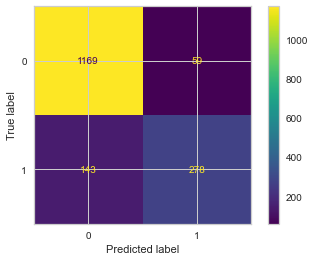

In [138]:
## 16,17,18 Prediction

pipe = Pipeline([('scaler',StandardScaler()), ('classifiers',CatBoostClassifier())])
pipe.fit(X_train,Y_train)
y_preds=pipe.predict(X_test)
print(pipe.score(X_test,Y_test))
metrics(Y_test,y_preds)
plot_confusion_matrix(pipe,X_test,Y_test)

In [139]:
## DO SMOTE ALG
smote = SMOTE(random_state=0)

X_train_over,Y_train_over = smote.fit_sample(X_train,Y_train)
#X_test_over,Y_test_over = smote.fit_sample(X_test,Y_test)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, Y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, Y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(Y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (3845, 30) (3845,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (5708, 30) (5708,)
SMOTE 적용 후 레이블 값 분포: 
 1    2854
0    2854
Name: HE_DM, dtype: int64


0.8580958156458459
ACC :  0.8580958156458459
Precision :  0.7220902612826603
recall(TP rate) :  0.7220902612826603
F1 :  0.7220902612826603
ROC SCORE :  0.8134066941592454


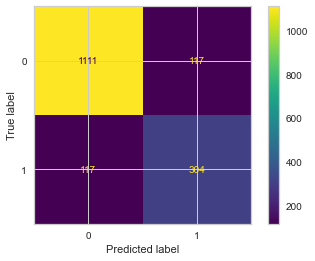

In [140]:
##PIPELINE RESAMPLED WORKFLOW
pipe = Pipeline([('scaler',StandardScaler()), ('classifiers',XGBClassifier())])
pipe.fit(X_train_over,Y_train_over)
#y_preds=pipe.predict(X_test_over)
y_preds=pipe.predict(X_test)
print(pipe.score(X_test,Y_test))
metrics(Y_test,y_preds)
plot_confusion_matrix(pipe,X_test,Y_test)

In [141]:
## K-FOLD VALIDATION 
scores = cross_val_score(estimator=pipe,
                         X=df.drop(columns=["HE_DM"]),
                         y=df.HE_DM,
                         #X=X_test_over,
                         #y=Y_test_over,
                         cv=10,
                         n_jobs=-1)
print('CV 정확도 점수: %s' % scores)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV 정확도 점수: [0.77818182 0.75636364 0.75818182 0.79090909 0.81785064 0.92349727
 0.92531876 0.89981785 0.90528233 0.8870674 ]
CV 정확도: 0.844 +/- 0.067


/Users/hobbes/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


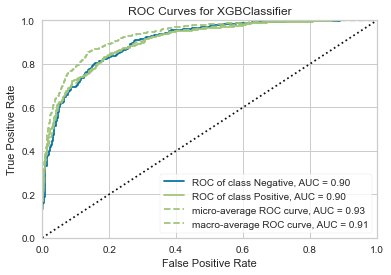

In [142]:
from yellowbrick.classifier import ROCAUC
 
 
visualizer = ROCAUC(pipe, classes=['Negative','Positive'])
visualizer.fit(X_train_over,Y_train_over)
visualizer.score(X_test, Y_test)
visualizer.show()

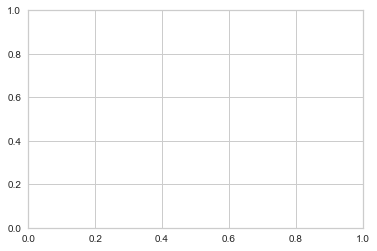

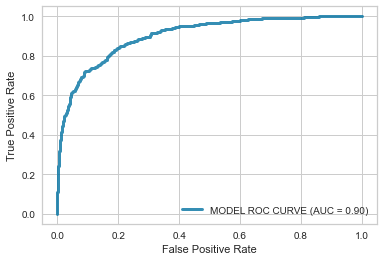

In [146]:
import matplotlib.pyplot as plt
ax=plt.subplots()

plot_roc_curve(pipe,X_test,Y_test,alpha=0.8, lw=3,drop_intermediate=True,name="MODEL ROC CURVE")
#plot_roc_curve(pipe,X_test,Y_test,alpha=0.8, lw=1,drop_intermediate=True,name="")

# ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
#         label='Chance', alpha=.8)
# plt.show()

In [ ]:
X.shape